# Прогнозирование оттока клиентов банка

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 
В распоряжении имеются исторические данные о поведении клиентов и расторжении договоров с банком и содержат следующие <b>признаки</b>:
- `RowNumber` — индекс строки в данных;
- `CustomerId` — уникальный идентификатор клиента;
- `Surname` — фамилия;
- `CreditScore` — кредитный рейтинг;
- `Geography` — страна проживания;
- `Gender` — пол;
- `Age` — возраст;
- `Tenure` — сколько лет человек является клиентом банка;
- `Balance` — баланс на счёте;
- `NumOfProducts` — количество продуктов банка, используемых клиентом;
- `HasCrCard` — наличие кредитной карты;
- `IsActiveMember` — активность клиента;
- `EstimatedSalary` — предполагаемая зарплата;

Exited — факт ухода клиента

и <b>целевой признак</b>:
- `Exited` — факт ухода клиента.

Примечания:
- Для оценки качества моделей необходимо применять метрику *F1*-меры.
- Дополнительно необходимо измерять *AUC-ROC*, сравнивайте её значение с *F1*-мерой.


Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Импорт необходимых библиотек:

In [313]:
import numpy as np
import optuna
import pandas as pd
import phik
import re

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

from matplotlib import pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

## 1. Подготовка данных

### 1.1. Загрузка данных и вывод основной информации

Чтение csv-файла и сохранение в переменную data

In [314]:
data = pd.read_csv('churn.csv')

In [315]:
# Функция, выводящая основную информацию о датафрейме
def about_df(data, size=5):
    print(f'Вывод первых {size} строк датафрейма:')
    pd.set_option('display.max_columns', 30)
    display(data.head(size))
    print('\nВывод основной информации о датафрейме:')
    data.info()
    print('\nКоличество пропусков в датафрейме:')
    print(pd.DataFrame(np.array([data.isna().sum(), data.isna().mean()*100]).T, 
                                columns=['количество пропусков', 'доля пропусков, %'], index=data.columns))
    print(f'\nСуммарное количество пропусков в датафрейме: {data.isna().sum().sum()}, '
          + f'доля пропусков: {round(data.isna().mean().sum()*100, 2)} %')
    display(data.describe())
    print('\n')
    for categ in data.columns[data.dtypes == 'object']:
        print(f'Уникальные значения столбца {categ}: {(data[categ].unique())}\n')

In [316]:
about_df(data)

Вывод первых 5 строк датафрейма:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0



Вывод основной информации о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB

Количество пропусков в датафрейме:
                 

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000




Уникальные значения столбца Surname: ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']

Уникальные значения столбца Geography: ['France' 'Spain' 'Germany']

Уникальные значения столбца Gender: ['Female' 'Male']



<b>Вывод:</b>
- датафрейм содержит 10000 строк и 14 столбцов;
- заголовки стобцов записаны в стиле Camel Case;
- столбец Gender имеет тип object;
- столбец Tenure (сколько лет человек является клиентом банка) содержит 909 пропущенных значений(9% от всех данных);
- столбец Exited - категориальный целевой признак (target), что соответствует задачи классификации;
- столбцы CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary являются признаками для обучения (features);
- столбцы RowNumber, CustomerId, Surname не являются информативными для целей нашего исследования.

### 1.2. Предобработка данных

#### 1.2.1. Изменение стиля заголовков столбцов

Изменим стиль заголовков столбцов на Snake Case

In [317]:
# Функция, изменяющая стиль заголовка из Camel Case в Snake Case
def camel_to_snake(string):
    string = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', string)
    string = re.sub('(.)([0-9]+)', r'\1_\2', string)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', string).lower()
new_name = []
for i in data.columns:
    new_name.append(camel_to_snake(i))
data = data.rename(columns=dict(zip(data.columns, new_name)))

Проверка изменения стиля заголовков столбцов:

In [318]:
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

#### 1.2.2. Обработка пропущенных значений

Так как доля пропущенных значений в столбце tenure составляет небольшую часть от всех данных (9%), удалим их:

In [319]:
data = data.dropna(subset=['tenure']).reset_index(drop=True)
data.shape[0]

9091

#### 1.2.3. Обработка дубликатов

Поиск явных дубликатов в датафрейме

In [320]:
data.duplicated().sum()

0

Поиск неявных дубликатов в датафрейме:

In [321]:
data[data[['surname', 'geography', 'gender', 'age', 'tenure', 'balance', 'estimated_salary']].
     duplicated(keep=False)].sort_values(by='surname')

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


#### Обработка аномальныз значений

Вывод количество значений столбца tenure:

In [322]:
data['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

Вывод уникальных значений столбца has_cr_card:

In [323]:
data['has_cr_card'].unique()

array([1, 0])

Вывод уникальных значений столбца is_active_member:

In [324]:
data['is_active_member'].unique()

array([1, 0])

Выведем строки со значением estimated_salary менее 100:

In [325]:
data.query('estimated_salary <= 100')

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
2129,2363,15791053,Lucciano,709,Germany,Male,45,4.0,122917.71,1,1,1,11.58,1
5027,5549,15639662,Phillips,710,France,Male,38,2.0,0.00,2,1,0,96.27,0
8184,9011,15786463,Hsing,645,Germany,Female,59,8.0,121669.93,2,0,0,91.75,1
8764,9648,15679693,Walker,625,France,Male,31,5.0,0.00,2,0,1,90.07,0


Т.к. таких значений немного, то удалим строки, в которых estimated_salary <= 100:

In [326]:
data = data.query('estimated_salary > 100')

#### 1.2.4. Удаление неинформативных признаков

Из выведенных характеристик в п. 1.1 и понимания области исследования, удалим неинформативные признаки:

In [327]:
data_edit = data.drop(['row_number', 'customer_id', 'surname'], axis=1)

#### 1.2.5. Проверка на мультиколлинеарность

In [328]:
phik_overview = data_edit.phik_matrix()
phik_overview.style.background_gradient()

interval columns not set, guessing: ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']


,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
credit_score,1.000000,0.049256,0.000000,0.000000,0.000000,0.000000,0.040050,0.009501,0.041057,0.040395,0.092580
geography,0.049256,1.000000,0.012060,0.083283,0.006453,0.464560,0.049015,0.006391,0.007569,0.023363,0.106876
gender,0.000000,0.012060,1.000000,0.032036,0.031210,0.011852,0.069776,0.000000,0.034933,0.027471,0.171329
age,0.000000,0.083283,0.032036,1.000000,0.046701,0.027472,0.144903,0.032573,0.189010,0.057268,0.486067
tenure,0.000000,0.006453,0.031210,0.046701,1.000000,0.063897,0.060155,0.031622,0.027497,0.000000,0.020652
balance,0.000000,0.464560,0.011852,0.027472,0.063897,1.000000,0.374208,0.053755,0.000000,0.000000,0.184441
num_of_products,0.040050,0.049015,0.069776,0.144903,0.060155,0.374208,1.000000,0.000000,0.058286,0.019758,0.561223
has_cr_card,0.009501,0.006391,0.000000,0.032573,0.031622,0.053755,0.000000,1.000000,0.000000,0.000000,0.000000
is_active_member,0.041057,0.007569,0.034933,0.189010,0.027497,0.000000,0.058286,0.000000,1.000000,0.038773,0.240370
estimated_salary,0.040395,0.023363,0.027471,0.057268,0.000000,0.000000,0.019758,0.000000,0.038773,1.000000,0.000000


<b>Вывод:</b> В результате предобработки данных были:
- изменен стиль заголовков столбцов из Camel Case на Snake Case;
- удалены пропуски в столбце tenure;
- дубликатов значений не обнаружено;
- удалены строки с аномально низкими значениями в столбце estimated_salary;
- cильной корреляции между признаками не выявлено.

## 2.  Исследование задачи

Выведем соотношение между классами:

Распределение классов:
0    0.796192
1    0.203808
Name: exited, dtype: float64


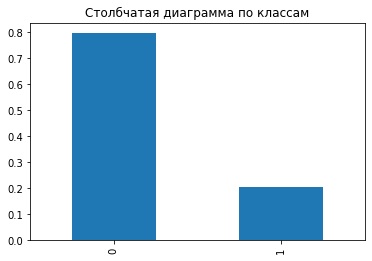

In [329]:
print('Распределение классов:')
class_frequency = data['exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title('Столбчатая диаграмма по классам')
plt.show()

Соотношение класса 0 к классу 1:

In [330]:
class_frequency[0]/class_frequency[1]

3.9065874730021592

<b>Вывод:</b>
- классы несбалансированны, их соотношение составляет примерно 4:1. 

### 2.1. Подготовка признаков для построения модели

In [331]:
# Функция, преобразующая техникой OHE категориальные признаки в числовые
def features_ohe(ohe_variable, df_features, features_categ):
    df_features_ohe = pd.DataFrame(
        data=ohe_variable.transform(df_features[features_categ]), 
        index=df_features.index,
        columns=ohe_variable.get_feature_names()
    )

    df_features = df_features.drop(features_categ, axis=1)
    df_features = df_features.join(df_features_ohe)
    return df_features    

Создание переменной features с признаками для обучения:

In [332]:
features = data_edit.drop('exited', axis=1)

Создание переменной target с целевым признаком exited:

In [333]:
target = data_edit['exited']

Разобьем выборку на две части: обучающую и тестовую(20%).

In [334]:
# Выделение 20% от исходных данных для тестовой выборки, остальное - для обучающей
features_train, features_test, target_train, target_test = train_test_split(
   features, target, test_size=0.2, random_state=12345, stratify=target)
print(features_train.shape, target_train.shape)
features_test.shape, target_test.shape

(7269, 10) (7269,)


((1818, 10), (1818,))

Списки категориальных и числовых признаков:

In [335]:
categorical = features.select_dtypes(include='object').columns.tolist()
numeric = features.select_dtypes(include='number').columns.tolist()

In [336]:
col_trans = make_column_transformer((StandardScaler(), numeric),
                                    (OneHotEncoder(drop='first', sparse_output=False), categorical),
                                    remainder='passthrough',
                                    n_jobs=-1)
col_trans

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['credit_score', 'age', 'tenure', 'balance',
                                  'num_of_products', 'has_cr_card',
                                  'is_active_member', 'estimated_salary']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['geography', 'gender'])])

<b>Вывод:</b> В ходе подготовки признаков для построения моделей:
- cоздана переменная features с признаками для обучения;
- создана переменная target с целевым признаком exited;
- выборка разбита на 2 части: обучающую (80%) и тестовую(20%);
- составлен pipepline, в котором задано масштабирование числовых признаков StandartScaler и преобразование категориальных признаков в числовые техникой OHE.

### 2.2. Построение моделей (без учета дисбаланса)

Исследуем три модели: логистическую регрессию, решающее дерево и случайный лес (без учета дисбаланса).

In [337]:
RANDOM_STATE = 12345
sampler = optuna.samplers.TPESampler(seed = RANDOM_STATE)

#### 2.2.1. Модель - логистическая регрессия

In [338]:
def objective(trial):
    param = {
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1']),
        'C': trial.suggest_float('C', 1e-7, 10.0, log=True),
    }
    model_lr= LogisticRegression(**param, random_state=RANDOM_STATE, solver='liblinear')
    pipeline_lr = make_pipeline(col_trans,  model_lr)
    
    f1_lr = cross_val_score(pipeline_lr, features_train, target_train, cv=5, scoring= 'f1').mean()
    roc_auc_lr = cross_val_score(pipeline_lr, features_train, target_train, cv=5, scoring= 'roc_auc').mean()
    return f1_lr, roc_auc_lr
study_lr = optuna.create_study(directions=['maximize', 'maximize'], sampler=sampler)
study_lr.optimize(objective, n_trials=5)

[I 2023-10-18 11:07:41,704] A new study created in memory with name: no-name-504bc7f6-a83c-4512-ad80-88f29581f37a
[I 2023-10-18 11:07:43,225] Trial 0 finished with values: [0.052743639977985333, 0.7372895903423643] and parameters: {'penalty': 'l2', 'C': 2.9604006672021068e-06}. 
[I 2023-10-18 11:07:44,638] Trial 1 finished with values: [0.07652875621426933, 0.7559416474069789] and parameters: {'penalty': 'l1', 'C': 0.005812428503452589}. 
[I 2023-10-18 11:07:45,513] Trial 2 finished with values: [0.3104566951334362, 0.769650084310677] and parameters: {'penalty': 'l2', 'C': 0.09800609837618245}. 
[I 2023-10-18 11:07:46,120] Trial 3 finished with values: [0.3174533202173568, 0.7694444150977597] and parameters: {'penalty': 'l1', 'C': 4.902909631584979}. 
[I 2023-10-18 11:07:46,708] Trial 4 finished with values: [0.0, 0.5] and parameters: {'penalty': 'l1', 'C': 2.4526168642455173e-05}. 


In [339]:
print(f'Наилучшие параметры модели: {study_lr.best_trials[0].params}\n' +
      f'F1 для логистической регрессии: {study_lr.best_trials[0].values[0]}\n' +
      f'AUC-ROC для логистической регрессии: {study_lr.best_trials[0].values[1]}')

Наилучшие параметры модели: {'penalty': 'l2', 'C': 0.09800609837618245}
F1 для логистической регрессии: 0.3104566951334362
AUC-ROC для логистической регрессии: 0.769650084310677


#### 2.2.2. Модель - решающее дерево

In [340]:
def objective(trial):
    param = {
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'max_depth': trial.suggest_int('max_depth', 5, 40),
    }
    model_dt= DecisionTreeClassifier(**param, random_state=RANDOM_STATE)
    pipeline_dt = make_pipeline(col_trans,  model_dt)
    f1_dt = cross_val_score(pipeline_dt, features_train, target_train, cv=5, scoring= 'f1').mean()
    roc_auc_dt = cross_val_score(pipeline_dt, features_train, target_train, cv=5, scoring= 'roc_auc').mean()
    return f1_dt, roc_auc_dt
study_dt = optuna.create_study(directions=['maximize', 'maximize'], sampler=sampler)
study_dt.optimize(objective, n_trials=5)

[I 2023-10-18 11:07:46,726] A new study created in memory with name: no-name-677e083c-5c5d-48b2-a665-025f92dfb317
[I 2023-10-18 11:07:47,574] Trial 0 finished with values: [0.5098637833507158, 0.7341606823111888] and parameters: {'min_samples_split': 11, 'max_depth': 34}. 
[I 2023-10-18 11:07:48,836] Trial 1 finished with values: [0.5184332505900869, 0.7434774423571215] and parameters: {'min_samples_split': 14, 'max_depth': 39}. 
[I 2023-10-18 11:07:49,929] Trial 2 finished with values: [0.518019621543907, 0.7407861147218282] and parameters: {'min_samples_split': 12, 'max_depth': 28}. 
[I 2023-10-18 11:07:50,942] Trial 3 finished with values: [0.5145334398702245, 0.7386353532846662] and parameters: {'min_samples_split': 12, 'max_depth': 21}. 
[I 2023-10-18 11:07:51,825] Trial 4 finished with values: [0.49344918488701595, 0.7118694839487906] and parameters: {'min_samples_split': 6, 'max_depth': 20}. 


In [341]:
print(f'Наилучшие параметры модели: {study_dt.best_trials[0].params}\n' +
      f'F1 для решающего дерева: {study_dt.best_trials[0].values[0]}\n' +
      f'AUC-ROC для решающего дерева: {study_dt.best_trials[0].values[1]}')

Наилучшие параметры модели: {'min_samples_split': 14, 'max_depth': 39}
F1 для решающего дерева: 0.5184332505900869
AUC-ROC для решающего дерева: 0.7434774423571215


#### 2.2.3. Модель - случайный лес

In [342]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 700),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
    }
    model_rf = RandomForestClassifier(**param, random_state=RANDOM_STATE)
    
    pipeline_rf = make_pipeline(col_trans, model_rf)
    
    f1_rf = cross_val_score(pipeline_rf, features_train, target_train, cv=5, scoring= 'f1').mean()
    roc_auc_rf = cross_val_score(pipeline_rf, features_train, target_train, cv=5, scoring= 'roc_auc').mean()
    return f1_rf, roc_auc_rf
study_rf = optuna.create_study(directions=['maximize', 'maximize'], sampler=sampler)
study_rf.optimize(objective, n_trials=5)

[I 2023-10-18 11:07:51,839] A new study created in memory with name: no-name-9980835d-e3be-4fe5-9205-78bed0343516
[I 2023-10-18 11:08:25,097] Trial 0 finished with values: [0.576581783008109, 0.8532081930055965] and parameters: {'n_estimators': 516, 'max_depth': 50}. 
[I 2023-10-18 11:08:55,247] Trial 1 finished with values: [0.5764964859287918, 0.8531755466883109] and parameters: {'n_estimators': 480, 'max_depth': 42}. 
[I 2023-10-18 11:09:05,763] Trial 2 finished with values: [0.5699047086360155, 0.8594825132237078] and parameters: {'n_estimators': 136, 'max_depth': 11}. 
[I 2023-10-18 11:09:55,828] Trial 3 finished with values: [0.5737415566023282, 0.8533916856251956] and parameters: {'n_estimators': 565, 'max_depth': 47}. 
[I 2023-10-18 11:09:59,407] Trial 4 finished with values: [0.5664364458754507, 0.8414650065134724] and parameters: {'n_estimators': 36, 'max_depth': 30}. 


In [343]:
print(f'Наилучшие параметры модели: {study_rf.best_trials[0].params}\n' +
      f'F1 для случайного леса: {study_rf.best_trials[0].values[0]}\n' +
      f'AUC-ROC для случайного леса: {study_rf.best_trials[0].values[1]}')

Наилучшие параметры модели: {'n_estimators': 516, 'max_depth': 50}
F1 для случайного леса: 0.576581783008109
AUC-ROC для случайного леса: 0.8532081930055965


<b>Вывод:</b> Сравним построенные модели по качеству (F1-мера и AUC-ROC) без учета дисбаланса:
- самое высокое качество у случайного леса, F1 равно <b>0.58</b>, AUC-ROC равно <b>0.85</b>, с гиперпараметрами:
    - n_estimators (количество деревьев) = 516, 
    - max_depth (максимальная глубина деревьев) = 50;
- на втором месте — дерево решений, F1 равно <b>0.52</b>, AUC-ROC равно <b>0.74</b> с гиперпараметрами:
    - max_depth (максимальная глубина дерева) = 39;
    - min_samples_split (минимальное количество выборок) = 14;
- самое низкое качество предсказания у логистической регрессии, F1 равно <b>0.31</b>, AUC-ROC равно <b>0.77</b>.

### 2.3. Борьба с дисбалансом

Исследуем три модели: логистическую регрессию, решающее дерево и случайный лес. 

Для каждой модели рассмотрим четыре способа устранения проблемы дисбаланса классов:
- взвешиванием классов;
- upsampling c помощью TomekLinks;
- downsampling с помощью SMOTE
- комбинированный способ SMOTETomek.

In [344]:
tomek_links = TomekLinks()
smote = SMOTE(random_state=RANDOM_STATE)
smotetomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE)

#### 2.3.1. Построение модели - логистическая регрессия (с учетом дисбаланса)

#### Способ 1 - взвешивание классов

In [345]:
def objective(trial):
    param = {
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1']),
        'C': trial.suggest_float('C', 1e-7, 10.0, log=True),
    }
    model_lr_1 = LogisticRegression(**param, random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced')
    
    pipeline_lr_1 = make_pipeline(col_trans,  model_lr_1)
    
    f1_lr_1 = cross_val_score(pipeline_lr_1, features_train, target_train, cv=5, scoring= 'f1').mean()
    roc_auc_lr_1 = cross_val_score(pipeline_lr_1, features_train, target_train, cv=5, scoring= 'roc_auc').mean()
    return f1_lr_1, roc_auc_lr_1
study_lr_1 = optuna.create_study(directions=['maximize', 'maximize'], sampler=sampler)
study_lr_1.optimize(objective, n_trials=5)

[I 2023-10-18 11:09:59,426] A new study created in memory with name: no-name-c2f02e49-2120-41a1-bc2b-c928a3e22c53
[I 2023-10-18 11:09:59,972] Trial 0 finished with values: [0.0, 0.5] and parameters: {'penalty': 'l1', 'C': 2.60411620928796e-07}. 
[I 2023-10-18 11:10:00,619] Trial 1 finished with values: [0.4973965071932239, 0.7728756855394219] and parameters: {'penalty': 'l2', 'C': 0.35220870951536204}. 
[I 2023-10-18 11:10:01,161] Trial 2 finished with values: [0.0, 0.5] and parameters: {'penalty': 'l1', 'C': 5.857984334574289e-07}. 
[I 2023-10-18 11:10:01,727] Trial 3 finished with values: [0.0, 0.5] and parameters: {'penalty': 'l1', 'C': 0.0005557072100843502}. 
[I 2023-10-18 11:10:02,281] Trial 4 finished with values: [0.0, 0.5] and parameters: {'penalty': 'l1', 'C': 2.657198796497881e-06}. 


In [346]:
print(f'Наилучшие параметры модели: {study_lr_1.best_trials[0].params}\n' +
      f'F1 для логистической регрессии: {study_lr_1.best_trials[0].values[0]}\n' +
      f'AUC-ROC для логистической регрессии: {study_lr_1.best_trials[0].values[1]}')

Наилучшие параметры модели: {'penalty': 'l2', 'C': 0.35220870951536204}
F1 для логистической регрессии: 0.4973965071932239
AUC-ROC для логистической регрессии: 0.7728756855394219


#### Способ 2 - upsampling

In [347]:
def objective(trial):
    param = {
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1']),
        'C': trial.suggest_float('C', 1e-7, 10.0, log=True),
    }
    model_lr_2 = LogisticRegression(**param, random_state=RANDOM_STATE, solver='liblinear')
    pipeline_lr_2 = Pipeline([
      ('col_trans', col_trans),
      ('smote', smote),
      ('model_lr_2', model_lr_2)
    ])
    f1_lr_2 = cross_val_score(pipeline_lr_2, features_train, target_train, cv=5, scoring= 'f1').mean()
    roc_auc_lr_2 = cross_val_score(pipeline_lr_2, features_train, target_train, cv=5, scoring= 'roc_auc').mean()
    return f1_lr_2, roc_auc_lr_2
study_lr_2 = optuna.create_study(directions=['maximize', 'maximize'], sampler=sampler)
study_lr_2.optimize(objective, n_trials=5)

[I 2023-10-18 11:10:02,334] A new study created in memory with name: no-name-325017d5-56a9-4767-86ba-c2f1d5bf1bb6
[I 2023-10-18 11:10:03,511] Trial 0 finished with values: [0.5002442899453625, 0.7721890324411138] and parameters: {'penalty': 'l2', 'C': 0.1414201674849644}. 
[I 2023-10-18 11:10:04,636] Trial 1 finished with values: [0.4644393968368837, 0.7564243032536391] and parameters: {'penalty': 'l2', 'C': 1.590259348686956e-06}. 
[I 2023-10-18 11:10:05,865] Trial 2 finished with values: [0.5003700824529914, 0.7721592585764153] and parameters: {'penalty': 'l2', 'C': 0.6149096318532045}. 
[I 2023-10-18 11:10:06,904] Trial 3 finished with values: [0.466876315532299, 0.7576672705740645] and parameters: {'penalty': 'l2', 'C': 3.3416982187394594e-05}. 
[I 2023-10-18 11:10:07,924] Trial 4 finished with values: [0.4645629270903284, 0.7563957146007272] and parameters: {'penalty': 'l2', 'C': 1.0156225865123087e-06}. 


In [348]:
print(f'Наилучшие параметры модели: {study_lr_2.best_trials[0].params}\n' +
      f'F1 для логистической регрессии: {study_lr_2.best_trials[0].values[0]}\n' +
      f'AUC-ROC для логистической регрессии: {study_lr_2.best_trials[0].values[1]}')

Наилучшие параметры модели: {'penalty': 'l2', 'C': 0.1414201674849644}
F1 для логистической регрессии: 0.5002442899453625
AUC-ROC для логистической регрессии: 0.7721890324411138


#### Способ 3 - downsampling

In [349]:
def objective(trial):
    param = {
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1']),
        'C': trial.suggest_float('C', 1e-7, 10.0, log=True),
    }
    model_lr_3 = LogisticRegression(**param, random_state=RANDOM_STATE, solver='liblinear')
    pipeline_lr_3 = Pipeline([
      ('col_trans', col_trans),
      ('tomek_links', tomek_links),
      ('model_lr_3', model_lr_3)
    ])
    f1_lr_3 = cross_val_score(pipeline_lr_3, features_train, target_train, cv=5, scoring= 'f1').mean()
    roc_auc_lr_3 = cross_val_score(pipeline_lr_3, features_train, target_train, cv=5, scoring= 'roc_auc').mean()
    return f1_lr_3, roc_auc_lr_3
study_lr_3 = optuna.create_study(directions=['maximize', 'maximize'], sampler=sampler)
study_lr_3.optimize(objective, n_trials=5)

[I 2023-10-18 11:10:07,947] A new study created in memory with name: no-name-da4deb85-597c-4b47-b809-8edfd9934a20
[I 2023-10-18 11:10:10,725] Trial 0 finished with values: [0.04130568050387627, 0.7484941953861147] and parameters: {'penalty': 'l1', 'C': 0.003875185724387857}. 
[I 2023-10-18 11:10:13,482] Trial 1 finished with values: [0.358024746577334, 0.7688300125134265] and parameters: {'penalty': 'l2', 'C': 1.2804829452967423}. 
[I 2023-10-18 11:10:16,256] Trial 2 finished with values: [0.34545025068510815, 0.768953510576029] and parameters: {'penalty': 'l2', 'C': 0.051741968633726654}. 
[I 2023-10-18 11:10:18,955] Trial 3 finished with values: [0.09406537023034084, 0.7418533843753614] and parameters: {'penalty': 'l2', 'C': 9.115815400556657e-06}. 
[I 2023-10-18 11:10:21,935] Trial 4 finished with values: [0.35785908080802364, 0.7688206844142107] and parameters: {'penalty': 'l2', 'C': 2.0929043815656247}. 


In [350]:
print(f'Наилучшие параметры модели: {study_lr_3.best_trials[0].params}\n' +
      f'F1 для логистической регрессии: {study_lr_3.best_trials[0].values[0]}\n' +
      f'AUC-ROC для логистической регрессии: {study_lr_3.best_trials[0].values[1]}')

Наилучшие параметры модели: {'penalty': 'l2', 'C': 1.2804829452967423}
F1 для логистической регрессии: 0.358024746577334
AUC-ROC для логистической регрессии: 0.7688300125134265


#### Способ 4 - комбинированный

In [351]:
def objective(trial):
    param = {
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1']),
        'C': trial.suggest_float('C', 1e-7, 10.0, log=True),
    }
    model_lr_4 = LogisticRegression(**param, random_state=RANDOM_STATE, solver='liblinear')
    pipeline_lr_4 = Pipeline([
      ('col_trans', col_trans),
      ('smotetomek', smotetomek),
      ('model_lr_4', model_lr_4)
    ])
    f1_lr_4 = cross_val_score(pipeline_lr_4, features_train, target_train, cv=5, scoring= 'f1').mean()
    roc_auc_lr_4 = cross_val_score(pipeline_lr_4, features_train, target_train, cv=5, scoring= 'roc_auc').mean()
    return f1_lr_4, roc_auc_lr_4
study_lr_4 = optuna.create_study(directions=['maximize', 'maximize'], sampler=sampler)
study_lr_4.optimize(objective, n_trials=5)

[I 2023-10-18 11:10:21,961] A new study created in memory with name: no-name-07d00a7f-cd2a-4d70-b4a6-936abb90ec4b
[I 2023-10-18 11:10:25,530] Trial 0 finished with values: [0.46405013146860197, 0.756505949678506] and parameters: {'penalty': 'l2', 'C': 1.0469857155393844e-05}. 
[I 2023-10-18 11:10:29,100] Trial 1 finished with values: [0.48715551967604076, 0.7675057199210137] and parameters: {'penalty': 'l2', 'C': 0.0009754107626848873}. 
[I 2023-10-18 11:10:32,712] Trial 2 finished with values: [0.49973285036183457, 0.7729048526750395] and parameters: {'penalty': 'l1', 'C': 0.01609957060343895}. 
[I 2023-10-18 11:10:36,461] Trial 3 finished with values: [0.5001111168048945, 0.7722734501741313] and parameters: {'penalty': 'l1', 'C': 0.17976155944725253}. 
[I 2023-10-18 11:10:40,073] Trial 4 finished with values: [0.0, 0.5] and parameters: {'penalty': 'l1', 'C': 7.220766438348848e-07}. 


In [352]:
print(f'Наилучшие параметры модели: {study_lr_4.best_trials[0].params}\n' +
      f'F1 для логистической регрессии: {study_lr_4.best_trials[0].values[0]}\n' +
      f'AUC-ROC для логистической регрессии: {study_lr_4.best_trials[0].values[1]}')

Наилучшие параметры модели: {'penalty': 'l1', 'C': 0.01609957060343895}
F1 для логистической регрессии: 0.49973285036183457
AUC-ROC для логистической регрессии: 0.7729048526750395


#### 2.3.2. Построение модели - решающее дерево (с учетом дисбаланса)

#### Способ 1 - взвешивание классов

In [353]:
def objective(trial):
    param = {
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'max_depth': trial.suggest_int('max_depth', 5, 40),
    }
    model_dt_1= DecisionTreeClassifier(**param, random_state=RANDOM_STATE, class_weight='balanced')
    pipeline_dt_1 = make_pipeline(col_trans,  model_dt_1)
    f1_dt_1 = cross_val_score(pipeline_dt_1, features_train, target_train, cv=5, scoring= 'f1').mean()
    roc_auc_dt_1 = cross_val_score(pipeline_dt_1, features_train, target_train, cv=5, scoring= 'roc_auc').mean()
    return f1_dt_1, roc_auc_dt_1
study_dt_1 = optuna.create_study(directions=['maximize', 'maximize'], sampler=sampler)
study_dt_1.optimize(objective, n_trials=5)

[I 2023-10-18 11:10:40,099] A new study created in memory with name: no-name-1bc3d7b1-a265-4ef2-a5fc-729af682e7ef
[I 2023-10-18 11:10:40,859] Trial 0 finished with values: [0.5162522393122446, 0.7422574164241802] and parameters: {'min_samples_split': 14, 'max_depth': 17}. 
[I 2023-10-18 11:10:41,638] Trial 1 finished with values: [0.5136404883178989, 0.7383687193370927] and parameters: {'min_samples_split': 13, 'max_depth': 37}. 
[I 2023-10-18 11:10:42,346] Trial 2 finished with values: [0.5213627234503116, 0.7165030595129711] and parameters: {'min_samples_split': 2, 'max_depth': 12}. 
[I 2023-10-18 11:10:43,186] Trial 3 finished with values: [0.5050862929779, 0.7062407887551976] and parameters: {'min_samples_split': 6, 'max_depth': 27}. 
[I 2023-10-18 11:10:44,136] Trial 4 finished with values: [0.5506472141214187, 0.7564266174340692] and parameters: {'min_samples_split': 3, 'max_depth': 10}. 


In [354]:
print(f'Наилучшие параметры модели: {study_dt_1.best_trials[0].params}\n' +
      f'F1 для решающего дерева: {study_dt_1.best_trials[0].values[0]}\n' +
      f'AUC-ROC для решающего дерева: {study_dt_1.best_trials[0].values[1]}')

Наилучшие параметры модели: {'min_samples_split': 3, 'max_depth': 10}
F1 для решающего дерева: 0.5506472141214187
AUC-ROC для решающего дерева: 0.7564266174340692


#### Способ 2 - upsampling

In [355]:
def objective(trial):
    param = {
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'max_depth': trial.suggest_int('max_depth', 5, 40),
    }
    model_dt_2= DecisionTreeClassifier(**param, random_state=RANDOM_STATE)
    pipeline_dt_2 = Pipeline([
      ('col_trans', col_trans),
      ('smote', smote),
      ('model_dt_2', model_dt_2)
    ])
    f1_dt_2 = cross_val_score(pipeline_dt_2, features_train, target_train, cv=5, scoring= 'f1').mean()
    roc_auc_dt_2 = cross_val_score(pipeline_dt_2, features_train, target_train, cv=5, scoring= 'roc_auc').mean()
    return f1_dt_2, roc_auc_dt_2
study_dt_2 = optuna.create_study(directions=['maximize', 'maximize'], sampler=sampler)
study_dt_2.optimize(objective, n_trials=5)

[I 2023-10-18 11:10:44,152] A new study created in memory with name: no-name-fbb83068-660c-4700-b11d-a83d75cfb1dc
[I 2023-10-18 11:10:45,695] Trial 0 finished with values: [0.5302912246534325, 0.7502764665464061] and parameters: {'min_samples_split': 9, 'max_depth': 29}. 
[I 2023-10-18 11:10:47,058] Trial 1 finished with values: [0.5299539127807669, 0.7621980902217556] and parameters: {'min_samples_split': 13, 'max_depth': 28}. 
[I 2023-10-18 11:10:48,584] Trial 2 finished with values: [0.5305792117711015, 0.7512516561244512] and parameters: {'min_samples_split': 10, 'max_depth': 30}. 
[I 2023-10-18 11:10:49,959] Trial 3 finished with values: [0.5190003383081682, 0.7253064284290633] and parameters: {'min_samples_split': 5, 'max_depth': 37}. 
[I 2023-10-18 11:10:50,956] Trial 4 finished with values: [0.5432731344372608, 0.8192842397360065] and parameters: {'min_samples_split': 8, 'max_depth': 5}. 


In [356]:
print(f'Наилучшие параметры модели: {study_dt_2.best_trials[0].params}\n' +
      f'F1 для решающего дерева: {study_dt_2.best_trials[0].values[0]}\n' +
      f'AUC-ROC для решающего дерева: {study_dt_2.best_trials[0].values[1]}')

Наилучшие параметры модели: {'min_samples_split': 8, 'max_depth': 5}
F1 для решающего дерева: 0.5432731344372608
AUC-ROC для решающего дерева: 0.8192842397360065


#### Способ 3 - downsampling

In [357]:
def objective(trial):
    param = {
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'max_depth': trial.suggest_int('max_depth', 5, 40),
    }
    model_dt_3= DecisionTreeClassifier(**param, random_state=RANDOM_STATE)
    pipeline_dt_3 = Pipeline([
      ('col_trans', col_trans),
      ('tomek_links', tomek_links),
      ('model_dt_3', model_dt_3)
    ])
    f1_dt_3 = cross_val_score(pipeline_dt_3, features_train, target_train, cv=5, scoring= 'f1').mean()
    roc_auc_dt_3 = cross_val_score(pipeline_dt_3, features_train, target_train, cv=5, scoring= 'roc_auc').mean()
    return f1_dt_3, roc_auc_dt_3
study_dt_3 = optuna.create_study(directions=['maximize', 'maximize'], sampler=sampler)
study_dt_3.optimize(objective, n_trials=5)

[I 2023-10-18 11:10:50,971] A new study created in memory with name: no-name-691eb8d1-50fa-4039-8f03-f212483c666d
[I 2023-10-18 11:10:53,792] Trial 0 finished with values: [0.5297762139770569, 0.769010911578371] and parameters: {'min_samples_split': 15, 'max_depth': 28}. 
[I 2023-10-18 11:10:56,497] Trial 1 finished with values: [0.5202066362532785, 0.7402214966537899] and parameters: {'min_samples_split': 9, 'max_depth': 29}. 
[I 2023-10-18 11:10:59,209] Trial 2 finished with values: [0.5209481815084405, 0.7352604867202877] and parameters: {'min_samples_split': 8, 'max_depth': 38}. 
[I 2023-10-18 11:11:01,693] Trial 3 finished with values: [0.5902168700347609, 0.8332849045055047] and parameters: {'min_samples_split': 9, 'max_depth': 7}. 
[I 2023-10-18 11:11:04,340] Trial 4 finished with values: [0.5202066362532785, 0.7402214966537899] and parameters: {'min_samples_split': 9, 'max_depth': 27}. 


In [358]:
print(f'Наилучшие параметры модели: {study_dt_3.best_trials[0].params}\n' +
      f'F1 для решающего дерева: {study_dt_3.best_trials[0].values[0]}\n' +
      f'AUC-ROC для решающего дерева: {study_dt_3.best_trials[0].values[1]}')

Наилучшие параметры модели: {'min_samples_split': 9, 'max_depth': 7}
F1 для решающего дерева: 0.5902168700347609
AUC-ROC для решающего дерева: 0.8332849045055047


#### Способ 4 - комбинированный

In [359]:
def objective(trial):
    param = {
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'max_depth': trial.suggest_int('max_depth', 5, 40),
    }
    model_dt_4= DecisionTreeClassifier(**param, random_state=RANDOM_STATE)
    pipeline_dt_4 = Pipeline([
      ('col_trans', col_trans),
      ('smotetomek', smotetomek),
      ('model_dt_4', model_dt_4)
    ])
    f1_dt_4 = cross_val_score(pipeline_dt_4, features_train, target_train, cv=5, scoring= 'f1').mean()
    roc_auc_dt_4 = cross_val_score(pipeline_dt_4, features_train, target_train, cv=5, scoring= 'roc_auc').mean()
    return f1_dt_4, roc_auc_dt_4
study_dt_4 = optuna.create_study(directions=['maximize', 'maximize'], sampler=sampler)
study_dt_4.optimize(objective, n_trials=5)

[I 2023-10-18 11:11:04,355] A new study created in memory with name: no-name-ab6a56e1-f339-4b88-bf0e-cb66da87092c
[I 2023-10-18 11:11:08,184] Trial 0 finished with values: [0.5209590008295342, 0.7650051864379164] and parameters: {'min_samples_split': 15, 'max_depth': 19}. 
[I 2023-10-18 11:11:11,893] Trial 1 finished with values: [0.5799206209773267, 0.8118144151062442] and parameters: {'min_samples_split': 5, 'max_depth': 8}. 
[I 2023-10-18 11:11:15,785] Trial 2 finished with values: [0.5081861188806789, 0.7402316556523489] and parameters: {'min_samples_split': 8, 'max_depth': 21}. 
[I 2023-10-18 11:11:19,609] Trial 3 finished with values: [0.5066007359610387, 0.6961479833983765] and parameters: {'min_samples_split': 2, 'max_depth': 29}. 
[I 2023-10-18 11:11:23,420] Trial 4 finished with values: [0.515649208601143, 0.7547040834296321] and parameters: {'min_samples_split': 12, 'max_depth': 31}. 


In [360]:
print(f'Наилучшие параметры модели: {study_dt_4.best_trials[0].params}\n' +
      f'F1 для решающего дерева: {study_dt_4.best_trials[0].values[0]}\n' +
      f'AUC-ROC для решающего дерева: {study_dt_4.best_trials[0].values[1]}')

Наилучшие параметры модели: {'min_samples_split': 5, 'max_depth': 8}
F1 для решающего дерева: 0.5799206209773267
AUC-ROC для решающего дерева: 0.8118144151062442


#### 2.3.3. Построение модели - случайный лес (с учетом дисбаланса)

#### Способ 1 - взвешивание классов

In [372]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 700),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
    }
    model_rf_1 = RandomForestClassifier(**param, random_state=RANDOM_STATE, class_weight='balanced')
    pipeline_rf_1 = make_pipeline(col_trans, model_rf_1)
    f1_rf_1 = cross_val_score(pipeline_rf_1, features_train, target_train, cv=5, scoring= 'f1').mean()
    roc_auc_rf_1 = cross_val_score(pipeline_rf_1, features_train, target_train, cv=5, scoring= 'roc_auc').mean()
    return f1_rf_1, roc_auc_rf_1
study_rf_1 = optuna.create_study(directions=['maximize', 'maximize'], sampler=sampler)
study_rf_1.optimize(objective, n_trials=5)

[I 2023-10-18 11:33:16,624] A new study created in memory with name: no-name-60c4b599-3308-4473-9b47-29f24cd521c0
[I 2023-10-18 11:33:43,106] Trial 0 finished with values: [0.5651460971242364, 0.8524643745087508] and parameters: {'n_estimators': 262, 'max_depth': 46}. 
[I 2023-10-18 11:34:35,460] Trial 1 finished with values: [0.5683025942811993, 0.853982651239521] and parameters: {'n_estimators': 611, 'max_depth': 49}. 
[I 2023-10-18 11:34:37,426] Trial 2 finished with values: [0.6079157603512404, 0.8480937512382176] and parameters: {'n_estimators': 20, 'max_depth': 10}. 
[I 2023-10-18 11:34:57,780] Trial 3 finished with values: [0.5668649001142698, 0.8525632575797768] and parameters: {'n_estimators': 233, 'max_depth': 50}. 
[I 2023-10-18 11:35:08,465] Trial 4 finished with values: [0.5741486707293242, 0.8517697420055953] and parameters: {'n_estimators': 121, 'max_depth': 16}. 


In [374]:
print(f'Наилучшие параметры модели: {study_rf_1.best_trials[0].params}\n' +
      f'F1 для случайного леса: {study_rf_1.best_trials[0].values[0]}\n' +
      f'AUC-ROC для случайного леса: {study_rf_1.best_trials[0].values[1]}')

Наилучшие параметры модели: {'n_estimators': 611, 'max_depth': 49}
F1 для случайного леса: 0.5683025942811993
AUC-ROC для случайного леса: 0.853982651239521


#### Способ 2 - upsampling

In [363]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 700),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
    }
    model_rf_2 = RandomForestClassifier(**param, random_state=RANDOM_STATE)
    pipeline_rf_2 = Pipeline([
      ('col_trans', col_trans),
      ('smote', smote),
      ('model_rf_2', model_rf_2)
    ])
    f1_rf_2 = cross_val_score(pipeline_rf_2, features_train, target_train, cv=5, scoring= 'f1').mean()
    roc_auc_rf_2 = cross_val_score(pipeline_rf_2, features_train, target_train, cv=5, scoring= 'roc_auc').mean()
    return f1_rf_2, roc_auc_rf_2
study_rf_2 = optuna.create_study(directions=['maximize', 'maximize'], sampler=sampler)
study_rf_2.optimize(objective, n_trials=5)

[I 2023-10-18 11:13:41,081] A new study created in memory with name: no-name-5f544c10-c87e-42d6-ac71-6e45f5ab2aaa
[I 2023-10-18 11:15:17,766] Trial 0 finished with values: [0.6000743666741691, 0.8512665784755642] and parameters: {'n_estimators': 611, 'max_depth': 21}. 
[I 2023-10-18 11:16:23,435] Trial 1 finished with values: [0.5962923256088033, 0.8511964305489078] and parameters: {'n_estimators': 418, 'max_depth': 28}. 
[I 2023-10-18 11:17:11,024] Trial 2 finished with values: [0.5957698258185383, 0.8506376268634666] and parameters: {'n_estimators': 300, 'max_depth': 46}. 
[I 2023-10-18 11:18:28,823] Trial 3 finished with values: [0.5984712788793548, 0.8513279974368931] and parameters: {'n_estimators': 491, 'max_depth': 21}. 
[I 2023-10-18 11:18:39,289] Trial 4 finished with values: [0.5882969231922746, 0.8464411371314498] and parameters: {'n_estimators': 63, 'max_depth': 18}. 


In [364]:
print(f'Наилучшие параметры модели: {study_rf_2.best_trials[0].params}\n' +
      f'F1 для случайного леса: {study_rf_2.best_trials[0].values[0]}\n' +
      f'AUC-ROC для случайного леса: {study_rf_2.best_trials[0].values[1]}')

Наилучшие параметры модели: {'n_estimators': 611, 'max_depth': 21}
F1 для случайного леса: 0.6000743666741691
AUC-ROC для случайного леса: 0.8512665784755642


#### Способ 3 - downsampling

In [365]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 700),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
    }
    model_rf_3 = RandomForestClassifier(**param, random_state=RANDOM_STATE)
    pipeline_rf_3 = Pipeline([
      ('col_trans', col_trans),
      ('tomek_links', tomek_links),
      ('model_rf_3', model_rf_3)
    ])
    f1_rf_3 = cross_val_score(pipeline_rf_3, features_train, target_train, cv=5, scoring= 'f1').mean()
    roc_auc_rf_3 = cross_val_score(pipeline_rf_3, features_train, target_train, cv=5, scoring= 'roc_auc').mean()
    return f1_rf_3, roc_auc_rf_3
study_rf_3 = optuna.create_study(directions=['maximize', 'maximize'], sampler=sampler)
study_rf_3.optimize(objective, n_trials=5)

[I 2023-10-18 11:18:39,304] A new study created in memory with name: no-name-588ff4da-b945-472c-8de0-a94e55192910
[I 2023-10-18 11:19:36,311] Trial 0 finished with values: [0.5983324778443473, 0.8546504126018156] and parameters: {'n_estimators': 654, 'max_depth': 45}. 
[I 2023-10-18 11:20:28,551] Trial 1 finished with values: [0.5967358487867165, 0.8603932410461489] and parameters: {'n_estimators': 670, 'max_depth': 12}. 
[I 2023-10-18 11:21:05,006] Trial 2 finished with values: [0.6010129168815472, 0.8543979932235303] and parameters: {'n_estimators': 414, 'max_depth': 29}. 
[I 2023-10-18 11:21:10,125] Trial 3 finished with values: [0.5893866401279019, 0.8457838648020285] and parameters: {'n_estimators': 34, 'max_depth': 25}. 
[I 2023-10-18 11:21:37,321] Trial 4 finished with values: [0.5991545920345093, 0.853723740189654] and parameters: {'n_estimators': 301, 'max_depth': 34}. 


In [366]:
print(f'Наилучшие параметры модели: {study_rf_3.best_trials[0].params}\n' +
      f'F1 для случайного леса: {study_rf_3.best_trials[0].values[0]}\n' +
      f'AUC-ROC для случайного леса: {study_rf_3.best_trials[0].values[1]}')

Наилучшие параметры модели: {'n_estimators': 654, 'max_depth': 45}
F1 для случайного леса: 0.5983324778443473
AUC-ROC для случайного леса: 0.8546504126018156


#### Способ 4 комбинированный

In [367]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 700),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
    }
    model_rf_4 = RandomForestClassifier(**param, random_state=RANDOM_STATE)
    pipeline_rf_4 = Pipeline([
      ('col_trans', col_trans),
      ('smotetomek', smotetomek),
      ('model_rf_4', model_rf_4)
    ])
    f1_rf_4 = cross_val_score(pipeline_rf_4, features_train, target_train, cv=5, scoring= 'f1').mean()
    roc_auc_rf_4 = cross_val_score(pipeline_rf_4, features_train, target_train, cv=5, scoring= 'roc_auc').mean()
    return f1_rf_4, roc_auc_rf_4
study_rf_4 = optuna.create_study(directions=['maximize', 'maximize'], sampler=sampler)
study_rf_4.optimize(objective, n_trials=5)

[I 2023-10-18 11:21:37,335] A new study created in memory with name: no-name-6692296d-94b2-4261-96d5-e3df314edec6
[I 2023-10-18 11:22:53,760] Trial 0 finished with values: [0.5928690987637661, 0.8516538333441023] and parameters: {'n_estimators': 477, 'max_depth': 44}. 
[I 2023-10-18 11:24:21,541] Trial 1 finished with values: [0.5911933590413117, 0.851578402593932] and parameters: {'n_estimators': 550, 'max_depth': 26}. 
[I 2023-10-18 11:25:51,646] Trial 2 finished with values: [0.5918457395428677, 0.8516636134158839] and parameters: {'n_estimators': 561, 'max_depth': 46}. 
[I 2023-10-18 11:26:25,454] Trial 3 finished with values: [0.5936743524758353, 0.8501850176946236] and parameters: {'n_estimators': 198, 'max_depth': 50}. 
[I 2023-10-18 11:28:01,704] Trial 4 finished with values: [0.5919638376427856, 0.8516763093006035] and parameters: {'n_estimators': 601, 'max_depth': 39}. 


<b>Вывод:</b> Сравним построенные модели по качеству (F1-мера и AUC-ROC) с учетом дисбаланса:
- самое высокое качество у случайного леса наилушее качество F1 равно <b>0.6001</b>, AUC-ROC равно <b>0.8513</b>, после  upsampling с гиперпараметрами:
    - n_estimators = 611, 
    - max_depth = 21,
- у модели - дерево решений наилучшее качество F1 равно <b>0.5902</b>, AUC-ROC равно <b>0.8333</b> после  downsampling с гиперпараметрами:
    - max_depth = 7;
    - min_samples_split = 9; 
- у модели - логистическая регрессия наилучшее качество F1 равно <b>0.5002</b>, AUC-ROC равно <b>0.7722</b> после upsampling.

<b>Полученные результаты из п.2 и п.3 представим в виде таблицы:</b>

In [375]:
models = ['логистическая регрессия', 'решающее дерево', 'случайный лес']
result = {
    'F1, AUC-ROC без уч. дисбаланса': [[round(study_lr.best_trials[0].values[0], 4), round(study_lr.best_trials[0].values[1], 4)], 
                                       [round(study_dt.best_trials[0].values[0], 4), round(study_dt.best_trials[0].values[1], 4)], 
                                       [round(study_rf.best_trials[0].values[0], 4), round(study_rf.best_trials[0].values[1], 4)],
                                      ],
    'F1, AUC-ROC взвеш.классов': [[round(study_lr_1.best_trials[0].values[0], 4), round(study_lr_1.best_trials[0].values[1], 4)], 
                                  [round(study_dt_1.best_trials[0].values[0], 4), round(study_dt_1.best_trials[0].values[1], 4)], 
                                  [round(study_rf_1.best_trials[0].values[0], 4), round(study_rf_1.best_trials[0].values[1], 4)],
                                 ],
    'F1, AUC-ROC upsampling': [[round(study_lr_2.best_trials[0].values[0], 4), round(study_lr_2.best_trials[0].values[1], 4)], 
                               [round(study_dt_2.best_trials[0].values[0], 4), round(study_dt_2.best_trials[0].values[1], 4)], 
                               [round(study_rf_2.best_trials[0].values[0], 4), round(study_rf_2.best_trials[0].values[1], 4)],
                              ],
    'F1, AUC-ROC downsampling': [[round(study_lr_3.best_trials[0].values[0], 4), round(study_lr_3.best_trials[0].values[1], 4)], 
                                 [round(study_dt_3.best_trials[0].values[0], 4), round(study_dt_3.best_trials[0].values[1], 4)], 
                                 [round(study_rf_3.best_trials[0].values[0], 4), round(study_rf_3.best_trials[0].values[1], 4)],
                                ],
    'F1, AUC-ROC комбинированный': [[round(study_lr_4.best_trials[0].values[0], 4), round(study_lr_4.best_trials[0].values[1], 4)], 
                                    [round(study_dt_4.best_trials[0].values[0], 4), round(study_dt_4.best_trials[0].values[1], 4)], 
                                    [round(study_rf_4.best_trials[0].values[0], 4), round(study_rf_4.best_trials[0].values[1], 4)],
                                   ],
    
}
pd.DataFrame(data=result, index=models)

,"F1, AUC-ROC без уч. дисбаланса","F1, AUC-ROC взвеш.классов","F1, AUC-ROC upsampling","F1, AUC-ROC downsampling","F1, AUC-ROC комбинированный"
логистическая регрессия,"[0.3105, 0.7697]","[0.4974, 0.7729]","[0.5002, 0.7722]","[0.358, 0.7688]","[0.4997, 0.7729]"
решающее дерево,"[0.5184, 0.7435]","[0.5506, 0.7564]","[0.5433, 0.8193]","[0.5902, 0.8333]","[0.5799, 0.8118]"
случайный лес,"[0.5766, 0.8532]","[0.5683, 0.854]","[0.6001, 0.8513]","[0.5983, 0.8547]","[0.5929, 0.8517]"


<b>Вывод по п.2 и п.3:</b> 
- дисбаланс классов сильнее всего повлиял на метрику качества F1 для модели - логистическая регрессия;
- метрика AUC-ROC более устойчива к дисбалансу классов по сравнению с F1.

## 3. Тестирование модели

По итогам предыдущих пунктов наилучшее качество показала модель - случайный лес после upsampling. Проверим качество данной модели на тестовой выборке:

In [369]:
model_rf_2 = RandomForestClassifier(**study_rf_2.best_trials[0].params, random_state=RANDOM_STATE)
pipeline_rf_2 = Pipeline([
      ('col_trans', col_trans),
      ('smote', smote),
      ('model_rf_2', model_rf_2)
    ])
pipeline_rf_2.fit(features_train, target_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['credit_score', 'age',
                                                   'tenure', 'balance',
                                                   'num_of_products',
                                                   'has_cr_card',
                                                   'is_active_member',
                                                   'estimated_salary']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['geography', 'gender'])])),
                ('smote', SMOTE(random_state=12345)),
                ('model_rf_2',
                 RandomForestClassifier(max_depth=21, n_estimators=611,
                                        random_state=12345))])

In [370]:
predictions_test = pipeline_rf_2.predict(features_test)
result = f1_score(target_test, predictions_test)
print('F1:', result)

F1: 0.6079545454545454


In [371]:
probabilities_test = pipeline_rf_2.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC:', auc_roc)

AUC-ROC: 0.8486719432527937


<b>Вывод:</b> По итогам тестирования модели случаный лес после upsampling:
- F1-мера = 0.6080
- AUC-ROC = 0.8487

<b>ОБЩИЕ ВЫВОДЫ:</b> 

В результате исследования определено:
1. по качеству (F1-мера и AUC-ROC) <b>без учета дисбаланса</b>:
 - самое высокое качество у случайного леса, F1 равно <b>0.58</b>, AUC-ROC равно <b>0.85</b>, с гиперпараметрами:
    - n_estimators (количество деревьев) = 516, 
    - max_depth (максимальная глубина деревьев) = 50;
- на втором месте — дерево решений, F1 равно <b>0.52</b>, AUC-ROC равно <b>0.74</b> с гиперпараметрами:
    - max_depth (максимальная глубина дерева) = 39;
    - min_samples_split (минимальное количество выборок) = 14;
- самое низкое качество предсказания у логистической регрессии, F1 равно <b>0.31</b>, AUC-ROC равно <b>0.77</b>.

2. по качеству (F1-мера и AUC-ROC) <b>с учетом дисбаланса</b>:
- самое высокое качество у случайного леса наилушее качество F1 равно <b>0.6001</b>, AUC-ROC равно <b>0.8513</b>, после  upsampling с гиперпараметрами:
    - n_estimators = 611, 
    - max_depth = 21,
- у модели - дерево решений наилучшее качество F1 равно <b>0.5902</b>, AUC-ROC равно <b>0.8333</b> после  downsampling с гиперпараметрами:
    - max_depth = 7;
    - min_samples_split = 9; 
- у модели - логистическая регрессия наилучшее качество F1 равно <b>0.5002</b>, AUC-ROC равно <b>0.7722</b> после upsampling.

    
    
3. дисбаланс классов сильнее всего повлиял на метрику качества F1 для модели - логистическая регрессия;


4. метрика AUC-ROC более устойчива к дисбалансу классов по сравнению с F1;


5. По итогам тестирования модели случаный лес после upsampling:
- F1-мера = 0.6080
- AUC-ROC = 0.8487